In this notebook, we will train a custom neural network to generate item text embeddings using a contrastive learning framework. This approach will enable us to obtain custom item text embeddings of a specified dimension.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from sklearn.model_selection import train_test_split
from google.colab import drive
import os
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer
import random
import re
from tqdm import tqdm
import pickle

In [ ]:
EMB_DIM = 64
BATCH_SIZE = 1024 #256
EPOCHS = 300
TEMPERATURE = 0.07  # NT-Xent loss temperature
LR = 1e-3 #1e-4
MODEL_NAME = "distilbert-base-uncased"  # Transformer model for encoding text

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir = '/content/drive/MyDrive/ML/Reinforcement Learning/Final project/MIND'

In [ ]:
news_train_path = os.path.join(project_dir, 'MINDsmall_train/news.tsv')
news_train = pd.read_csv(news_train_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

news_dev_path = os.path.join(project_dir, 'MINDsmall_dev/news.tsv')
news_dev = pd.read_csv(news_dev_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

In [ ]:
behaviors_train_path = os.path.join(project_dir, 'processed_data/merged_behaviors_train.csv')
behaviors_train = pd.read_csv(behaviors_train_path)

behaviors_dev_path = os.path.join(project_dir, 'processed_data/merged_behaviors_dev.csv')
behaviors_dev = pd.read_csv(behaviors_dev_path)

In [ ]:
# check if any users are found in both train and dev sets

len(set(behaviors_train['user_id']).intersection(set(behaviors_dev['user_id'])))

5766

In [ ]:
# concatenate train and dev sets into a single dataframe
# remove user_id duplicates
# filter out users with histories consisting of less than 2 items

behaviors_df = pd.concat([behaviors_train, behaviors_dev], ignore_index=True, sort=False)
behaviors_df.drop_duplicates(subset='user_id', inplace=True, ignore_index=True)
behaviors_df = behaviors_df[behaviors_df['history'].apply(lambda x: len(x.split()))>1].reset_index(drop=True)

In [ ]:
def process_behaviors(row):
    # Get item IDs of clicked impressions (flag == 1)
    clicked_impressions = " ".join(i.split('-')[0] for i in row['impressions'].split() if int(i.split('-')[1]) == 1)

    # Get item IDs of non-clicked impressions (flag == 0)
    not_clicked_impressions = " ".join(i.split('-')[0] for i in row['impressions'].split() if int(i.split('-')[1]) == 0)

    # Append clicked items to the user's history
    row['history'] += " " + clicked_impressions

    # Update impressions to only include non-clicked items
    row['impressions'] = not_clicked_impressions

    return row

In [ ]:
behaviors_df = behaviors_df.apply(process_behaviors, axis=1)

In [ ]:
behaviors_df = behaviors_df[behaviors_df['impressions'].apply(lambda x: len(x.split()))>0].reset_index(drop=True)

In [ ]:
interactions = behaviors_df['history'].apply(lambda x: x.split()).values
negative_interactions = behaviors_df['impressions'].apply(lambda x: x.split()).values

In [ ]:
# concatenate train and dev news sets into a single dataframe
# remove news_id duplicates

news_df = pd.concat([news_train, news_dev], ignore_index=True, sort=False)
news_df.drop_duplicates(subset='news_id', inplace=True, ignore_index=True)

In [ ]:
def preprocess_subcategory(category, subcategory):

    if '-' in subcategory or '_' in subcategory:
        subcategory = subcategory.replace('-', ' ').replace('_', ' ')
        return subcategory

    if category.lower() in subcategory.lower():
        return ''
    else:
        return subcategory

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
news_df['proc_subcategory'] = news_df.apply(lambda row: preprocess_subcategory(row['category'], row['subcategory']), axis=1)

In [ ]:
news_df["text"] = news_df["category"] + " "\
+ news_df["proc_subcategory"] + " "\
+ news_df["title"] + " "\
+ news_df["abstract"].fillna('')

In [ ]:
news_df["text"] = news_df["text"].apply(preprocess_text)

In [ ]:
article_texts = news_df.set_index('news_id')['text'].to_dict()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_transformer = AutoModel.from_pretrained(MODEL_NAME)
model_transformer.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transformer.to(device)

precomputed_embeddings = {}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
for article_id, text in tqdm(article_texts.items(), total=len(article_texts)):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        embedding = model_transformer(**inputs).last_hidden_state[:, 0, :].squeeze(0)
    precomputed_embeddings[article_id] = embedding.cpu()  # store on CPU for later use

100%|██████████| 65238/65238 [05:41<00:00, 190.94it/s]


In [ ]:
# embeddings_path = os.path.join(project_dir, "precomputed_distilbert_embeddings.pkl")

# with open(embeddings_path, "wb") as f:
#     pickle.dump(precomputed_embeddings, f)

In [ ]:
# embeddings_path = os.path.join(project_dir, "precomputed_distilbert_embeddings.pkl")

# with open(embeddings_path, "rb") as f:
#     precomputed_embeddings = pickle.load(f)

In [ ]:
hidden_size = precomputed_embeddings[next(iter(precomputed_embeddings))].shape[0]

A custom dataset class samples triplets—anchor, positive, and negative examples—from user interactions. For each instance, it randomly selects two items from positive interactions (anchor and positive) and one from negative interactions, using precomputed embeddings.

In [ ]:
class ContrastiveDataset(Dataset):
    def __init__(self, interactions, negative_interactions, precomputed_embeddings):
        self.precomputed_embeddings = precomputed_embeddings
        self.samples = []

        for pos_history, neg_history in zip(interactions, negative_interactions):
            anchor, positive = random.sample(pos_history, 2)
            neg_article = random.choice(neg_history)
            self.samples.append((anchor, positive, neg_article))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        anchor, positive, negative = self.samples[idx]
        return (
            self.precomputed_embeddings[anchor],
            self.precomputed_embeddings[positive],
            self.precomputed_embeddings[negative]
        )

In [ ]:
indices = np.arange(len(interactions))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_pos = interactions[train_idx]
val_pos = interactions[val_idx]
train_neg = negative_interactions[train_idx]
val_neg = negative_interactions[val_idx]

In [ ]:
train_dataset = ContrastiveDataset(train_pos, train_neg, precomputed_embeddings)
val_dataset = ContrastiveDataset(val_pos, val_neg, precomputed_embeddings)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
for batch_idx, (pos1, pos2, neg) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print("Positive article 1:", pos1[0])
    print("Positive article 2:", pos2[0])
    print("Negative article:", neg[0])
    break

Batch 1
Positive article 1: tensor([-1.1032e-01, -2.8739e-02, -1.8919e-01,  1.0404e-02,  3.6093e-02,
        -3.8637e-01,  1.7702e-01,  2.8092e-01, -1.6235e-01, -3.5606e-01,
        -4.3496e-02, -3.3343e-01, -4.4933e-01,  2.7546e-01, -1.5729e-01,
         2.8898e-01,  3.6984e-02,  3.2629e-01,  2.9288e-01,  2.2231e-02,
        -1.5485e-02, -3.7064e-01,  4.3334e-01, -1.6086e-01,  7.1938e-02,
        -1.0941e-01, -1.8236e-01, -3.7941e-02, -2.5442e-01,  1.0013e-01,
         1.5796e-01, -7.7660e-03, -2.9355e-01, -3.5835e-01, -8.0623e-02,
        -1.1830e-01,  1.8411e-01,  1.0484e-01, -1.1350e-01,  3.9696e-01,
        -9.9241e-02,  1.4207e-01, -4.0804e-01, -2.3534e-01,  1.5857e-02,
        -6.8908e-03, -2.3072e+00, -2.1572e-01, -2.3318e-01, -3.5129e-01,
         2.1661e-01, -2.0969e-02, -1.8498e-02,  2.2357e-01,  4.0957e-02,
         2.7488e-01, -2.7499e-01, -1.8797e-01,  1.2367e-02, -1.1879e-01,
         1.6364e-01, -1.6894e-01, -1.3250e-01, -2.0655e-01,  4.0740e-02,
        -3.9745e-01, -2

A neural network (TextEncoder) transforms high-dimensional embeddings (e.g., from distilbert-base-uncased) into a lower-dimensional space. It uses two fully connected layers with ReLU activation and dropout to produce compact item embeddings.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, hidden_size, emb_dim=64, dropout_prob=0.5):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size // 2, emb_dim)

    def forward(self, embedding_batch):
        x = self.fc1(embedding_batch)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)

The NT-Xent loss function computes cosine similarities between the anchor-positive and anchor-negative pairs. It scales these similarities using a temperature parameter and applies binary cross-entropy loss to encourage the model to pull similar items together while pushing dissimilar ones apart.

In [ ]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=TEMPERATURE):
        super().__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, pos1, pos2, neg):
        pos_sim = self.cosine_similarity(pos1, pos2) / self.temperature
        neg_sim = self.cosine_similarity(pos1, neg) / self.temperature

        logits = torch.cat([pos_sim, neg_sim], dim=0)
        labels = torch.cat([torch.ones_like(pos_sim), torch.zeros_like(neg_sim)], dim=0)

        return nn.functional.binary_cross_entropy_with_logits(logits, labels)

In [ ]:
model = TextEncoder(hidden_size, EMB_DIM)
loss_fn = NTXentLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn.to(device)

NTXentLoss(
  (cosine_similarity): CosineSimilarity()
)

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
best_val_loss = float('inf')
early_stopping_counter = 0
EARLY_STOPPING_PATIENCE = 5

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training", leave=False)

    for text1, text2, text_neg in train_progress:

        optimizer.zero_grad()

        text1 = text1.to(device)
        text2 = text2.to(device)
        text_neg = text_neg.to(device)

        emb1 = model(text1)
        emb2 = model(text2)
        emb_neg = model(text_neg)

        loss = loss_fn(emb1, emb2, emb_neg)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_progress.set_postfix(loss=loss.item())

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation", leave=False)

        for text1, text2, text_neg in val_progress:

            text1 = text1.to(device)
            text2 = text2.to(device)
            text_neg = text_neg.to(device)

            emb1 = model(text1)
            emb2 = model(text2)
            emb_neg = model(text_neg)

            loss_val = loss_fn(emb1, emb2, emb_neg)
            val_loss += loss_val.item()
            val_progress.set_postfix(loss=loss_val.item())

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Check for improvement on validation loss and save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), os.path.join(project_dir, 'text_encoder_distilbest_model.pt'))
        print("New best model saved!")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    scheduler.step(avg_val_loss)

Epoch 1/300, Train Loss: 1.1612, Val Loss: 2.3732
New best model saved!


Epoch 2/300, Train Loss: 1.0348, Val Loss: 2.1374
New best model saved!


Epoch 3/300, Train Loss: 1.0111, Val Loss: 2.0489
New best model saved!


Epoch 4/300, Train Loss: 0.9968, Val Loss: 2.0623


Epoch 5/300, Train Loss: 0.9816, Val Loss: 1.9082
New best model saved!


Epoch 6/300, Train Loss: 0.9776, Val Loss: 1.8850
New best model saved!


Epoch 7/300, Train Loss: 0.9730, Val Loss: 1.8310
New best model saved!


Epoch 8/300, Train Loss: 0.9622, Val Loss: 1.7165
New best model saved!


Epoch 9/300, Train Loss: 0.9512, Val Loss: 1.6460
New best model saved!


Epoch 10/300, Train Loss: 0.9405, Val Loss: 1.5782
New best model saved!


Epoch 11/300, Train Loss: 0.9317, Val Loss: 1.4537
New best model saved!


Epoch 12/300, Train Loss: 0.9140, Val Loss: 1.3460
New best model saved!


Epoch 13/300, Train Loss: 0.9065, Val Loss: 1.3135
New best model saved!


Epoch 14/300, Train Loss: 0.8906, Val Loss: 1.2710
New best model saved!


Epoch 15/300, Train Loss: 0.8797, Val Loss: 1.2423
New best model saved!


Epoch 16/300, Train Loss: 0.8691, Val Loss: 1.0924
New best model saved!


Epoch 17/300, Train Loss: 0.8569, Val Loss: 1.1144


Epoch 18/300, Train Loss: 0.8422, Val Loss: 1.0425
New best model saved!


Epoch 19/300, Train Loss: 0.8321, Val Loss: 1.0264
New best model saved!


Epoch 20/300, Train Loss: 0.8205, Val Loss: 0.9413
New best model saved!


Epoch 21/300, Train Loss: 0.8091, Val Loss: 0.9234
New best model saved!


Epoch 22/300, Train Loss: 0.8096, Val Loss: 0.9516


Epoch 23/300, Train Loss: 0.8030, Val Loss: 0.8808
New best model saved!


Epoch 24/300, Train Loss: 0.7922, Val Loss: 0.8598
New best model saved!


Epoch 25/300, Train Loss: 0.7763, Val Loss: 0.8275
New best model saved!


Epoch 26/300, Train Loss: 0.7683, Val Loss: 0.8209
New best model saved!


Epoch 27/300, Train Loss: 0.7687, Val Loss: 0.7861
New best model saved!


Epoch 28/300, Train Loss: 0.7663, Val Loss: 0.7907


Epoch 29/300, Train Loss: 0.7641, Val Loss: 0.8028


Epoch 30/300, Train Loss: 0.7581, Val Loss: 0.7874


Epoch 31/300, Train Loss: 0.7526, Val Loss: 0.7916


Epoch 32/300, Train Loss: 0.7268, Val Loss: 0.7319
New best model saved!


Epoch 33/300, Train Loss: 0.7089, Val Loss: 0.7224
New best model saved!


Epoch 34/300, Train Loss: 0.6951, Val Loss: 0.7072
New best model saved!


Epoch 35/300, Train Loss: 0.6941, Val Loss: 0.7046
New best model saved!


Epoch 36/300, Train Loss: 0.6807, Val Loss: 0.7118


Epoch 37/300, Train Loss: 0.6788, Val Loss: 0.7043
New best model saved!


Epoch 38/300, Train Loss: 0.6773, Val Loss: 0.7029
New best model saved!


Epoch 39/300, Train Loss: 0.6792, Val Loss: 0.6990
New best model saved!


Epoch 40/300, Train Loss: 0.6758, Val Loss: 0.7032


Epoch 41/300, Train Loss: 0.6699, Val Loss: 0.6882
New best model saved!


Epoch 42/300, Train Loss: 0.6625, Val Loss: 0.7028


Epoch 43/300, Train Loss: 0.6638, Val Loss: 0.6959


Epoch 44/300, Train Loss: 0.6692, Val Loss: 0.7020


Epoch 45/300, Train Loss: 0.6669, Val Loss: 0.6844
New best model saved!


Epoch 46/300, Train Loss: 0.6657, Val Loss: 0.7024


Epoch 47/300, Train Loss: 0.6604, Val Loss: 0.6851


Epoch 48/300, Train Loss: 0.6554, Val Loss: 0.6842
New best model saved!


Epoch 49/300, Train Loss: 0.6590, Val Loss: 0.6993


Epoch 50/300, Train Loss: 0.6643, Val Loss: 0.6853


Epoch 51/300, Train Loss: 0.6706, Val Loss: 0.6994


Epoch 52/300, Train Loss: 0.6637, Val Loss: 0.6884


Epoch 53/300, Train Loss: 0.6395, Val Loss: 0.6757
New best model saved!


Epoch 54/300, Train Loss: 0.6313, Val Loss: 0.6672
New best model saved!


Epoch 55/300, Train Loss: 0.6229, Val Loss: 0.6691


Epoch 56/300, Train Loss: 0.6286, Val Loss: 0.6711


Epoch 57/300, Train Loss: 0.6205, Val Loss: 0.6651
New best model saved!


Epoch 58/300, Train Loss: 0.6177, Val Loss: 0.6678


Epoch 59/300, Train Loss: 0.6156, Val Loss: 0.6565
New best model saved!


Epoch 60/300, Train Loss: 0.6188, Val Loss: 0.6634


Epoch 61/300, Train Loss: 0.6158, Val Loss: 0.6551
New best model saved!


Epoch 62/300, Train Loss: 0.6150, Val Loss: 0.6649


Epoch 63/300, Train Loss: 0.6181, Val Loss: 0.6653


Epoch 64/300, Train Loss: 0.6148, Val Loss: 0.6575


Epoch 65/300, Train Loss: 0.6100, Val Loss: 0.6535
New best model saved!


Epoch 66/300, Train Loss: 0.6079, Val Loss: 0.6604


Epoch 67/300, Train Loss: 0.6109, Val Loss: 0.6611


Epoch 68/300, Train Loss: 0.6033, Val Loss: 0.6602


Epoch 69/300, Train Loss: 0.6019, Val Loss: 0.6525
New best model saved!


Epoch 70/300, Train Loss: 0.5996, Val Loss: 0.6561


Epoch 71/300, Train Loss: 0.6040, Val Loss: 0.6591


Epoch 72/300, Train Loss: 0.6055, Val Loss: 0.6509
New best model saved!


Epoch 73/300, Train Loss: 0.6039, Val Loss: 0.6525


Epoch 74/300, Train Loss: 0.6063, Val Loss: 0.6585


Epoch 75/300, Train Loss: 0.5980, Val Loss: 0.6490
New best model saved!


Epoch 76/300, Train Loss: 0.6055, Val Loss: 0.6559


Epoch 77/300, Train Loss: 0.5989, Val Loss: 0.6508


Epoch 78/300, Train Loss: 0.6042, Val Loss: 0.6493


Epoch 79/300, Train Loss: 0.5993, Val Loss: 0.6437
New best model saved!


Epoch 80/300, Train Loss: 0.5992, Val Loss: 0.6470


Epoch 81/300, Train Loss: 0.5903, Val Loss: 0.6464


Epoch 82/300, Train Loss: 0.5944, Val Loss: 0.6437
New best model saved!


Epoch 83/300, Train Loss: 0.5954, Val Loss: 0.6460


Epoch 84/300, Train Loss: 0.5875, Val Loss: 0.6361
New best model saved!


Epoch 85/300, Train Loss: 0.5856, Val Loss: 0.6354
New best model saved!


Epoch 86/300, Train Loss: 0.5853, Val Loss: 0.6361


Epoch 87/300, Train Loss: 0.5789, Val Loss: 0.6397


Epoch 88/300, Train Loss: 0.5807, Val Loss: 0.6335
New best model saved!


Epoch 89/300, Train Loss: 0.5769, Val Loss: 0.6343


Epoch 90/300, Train Loss: 0.5758, Val Loss: 0.6342


Epoch 91/300, Train Loss: 0.5738, Val Loss: 0.6348


Epoch 92/300, Train Loss: 0.5747, Val Loss: 0.6329
New best model saved!


Epoch 93/300, Train Loss: 0.5758, Val Loss: 0.6343


Epoch 94/300, Train Loss: 0.5759, Val Loss: 0.6313
New best model saved!


Epoch 95/300, Train Loss: 0.5721, Val Loss: 0.6378


Epoch 96/300, Train Loss: 0.5755, Val Loss: 0.6340


Epoch 97/300, Train Loss: 0.5713, Val Loss: 0.6270
New best model saved!


Epoch 98/300, Train Loss: 0.5709, Val Loss: 0.6340


Epoch 99/300, Train Loss: 0.5739, Val Loss: 0.6328


Epoch 100/300, Train Loss: 0.5740, Val Loss: 0.6331


Epoch 101/300, Train Loss: 0.5703, Val Loss: 0.6272


Epoch 102/300, Train Loss: 0.5683, Val Loss: 0.6282
Early stopping triggered at epoch 102


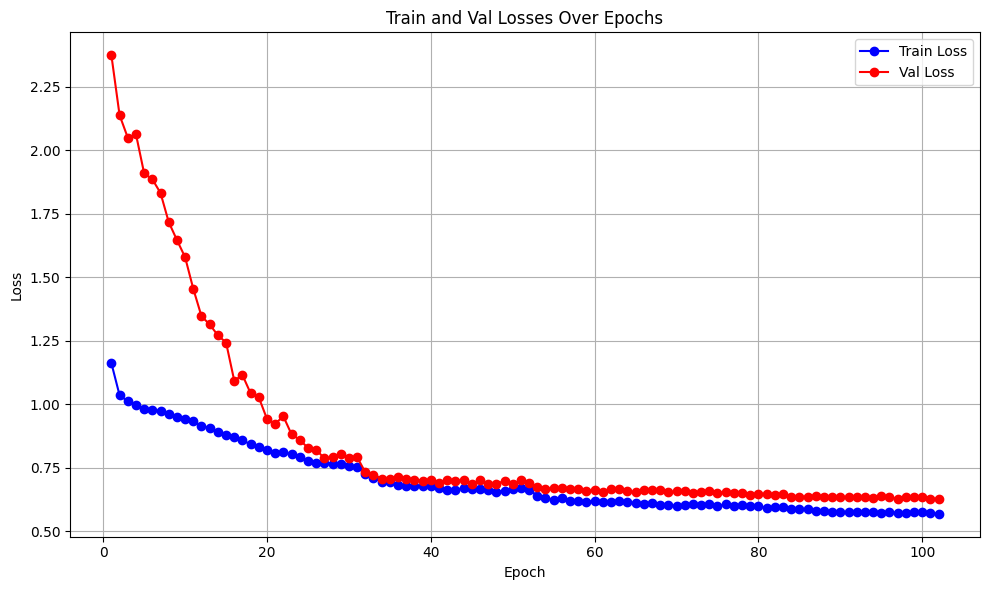

In [ ]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', linestyle='-', color='red', label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Losses Over Epochs')

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
best_model = TextEncoder(768, 64)
best_model.load_state_dict(torch.load(os.path.join(project_dir, 'text_encoder_distilbest_model.pt')))
best_model.to(device)
best_model.eval()

article_embeddings = {}

with torch.no_grad():
    for news_id, text in precomputed_embeddings.items():
        text_tensor = text.unsqueeze(0).to(device)
        embedding = best_model(text_tensor)
        article_embeddings[news_id] = embedding.squeeze(0).cpu().numpy()

In [ ]:
print(f"Min value: {np.min(np.concatenate(list(article_embeddings.values())))}")
print(f"Max value: {np.max(np.concatenate(list(article_embeddings.values())))}")

# Might need normalization later

Min value: -2.120283603668213
Max value: 1.6162680387496948


In [ ]:
# embeddings_path = os.path.join(project_dir, "all_news_custom_embeddings.pkl")

# with open(embeddings_path, "wb") as f:
#     pickle.dump(article_embeddings, f)

In [ ]:
embeddings_path = os.path.join(project_dir, "all_news_custom_embeddings.pkl")

with open(embeddings_path, "rb") as f:
    article_embeddings = pickle.load(f)

Now split the custom embeddings into train and dev and save them for later use.

In [ ]:
train_ids = set(news_train["news_id"])
dev_ids = set(news_dev["news_id"])

In [ ]:
train_custom_embeddings = {news_id: emb
                           for news_id, emb in article_embeddings.items()
                           if news_id in train_ids}

test_custom_embeddings = {news_id: emb
                          for news_id, emb in article_embeddings.items()
                          if news_id in dev_ids}

In [ ]:
# train_embeddings_path = os.path.join(project_dir, 'embeddings/news_train_custom_embeddings.pkl')
# dev_embeddings_path = os.path.join(project_dir, 'embeddings/news_dev_custom_embeddings.pkl')

# with open(train_embeddings_path, "wb") as f_train:
#     pickle.dump(train_custom_embeddings, f_train)

# with open(dev_embeddings_path, "wb") as f_test:
#     pickle.dump(test_custom_embeddings, f_test)